# Imports

In [28]:
import requests
import squarify
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import pandas as pd

## Tokens

In [ ]:
username = "prasadadhav"
token = "my_token_here" 

In [4]:
repos = requests.get(
    f"https://api.github.com/users/{username}/repos",
    headers={"Authorization": f"token {token}"}
).json()

# get languages

In [5]:
language_totals = {}

In [6]:
# Loop through repos and fetch language data
for repo in repos:
    repo_name = repo["name"]
    lang_url = f"https://api.github.com/repos/{username}/{repo_name}/languages"
    langs = requests.get(lang_url, headers={"Authorization": f"token {token}"}).json()
    for lang, bytes_of_code in langs.items():
        language_totals[lang] = language_totals.get(lang, 0) + bytes_of_code


## Plots

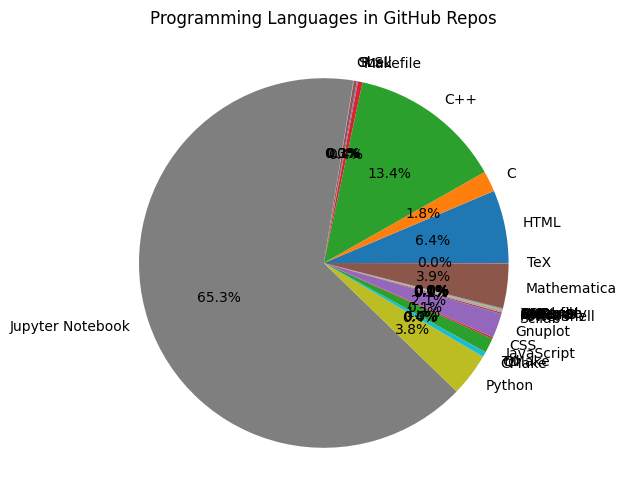

In [7]:
# Plot
plt.figure(figsize=(8, 6))
plt.pie(language_totals.values(), labels=language_totals.keys(), autopct='%1.1f%%')
plt.title("Programming Languages in GitHub Repos")
plt.show()

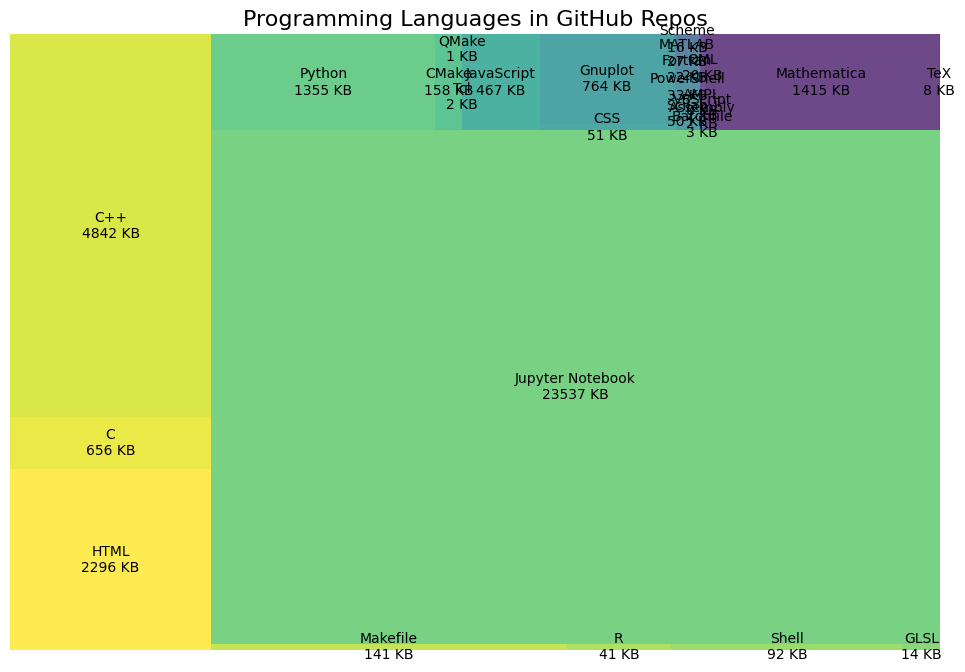

In [8]:
labels = [f"{k}\n{v//1000} KB" for k, v in language_totals.items()]
sizes = list(language_totals.values())
colors = plt.cm.viridis_r([i/len(sizes) for i in range(len(sizes))])

plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8)
plt.axis('off')
plt.title("Programming Languages in GitHub Repos", fontsize=16)
plt.show()

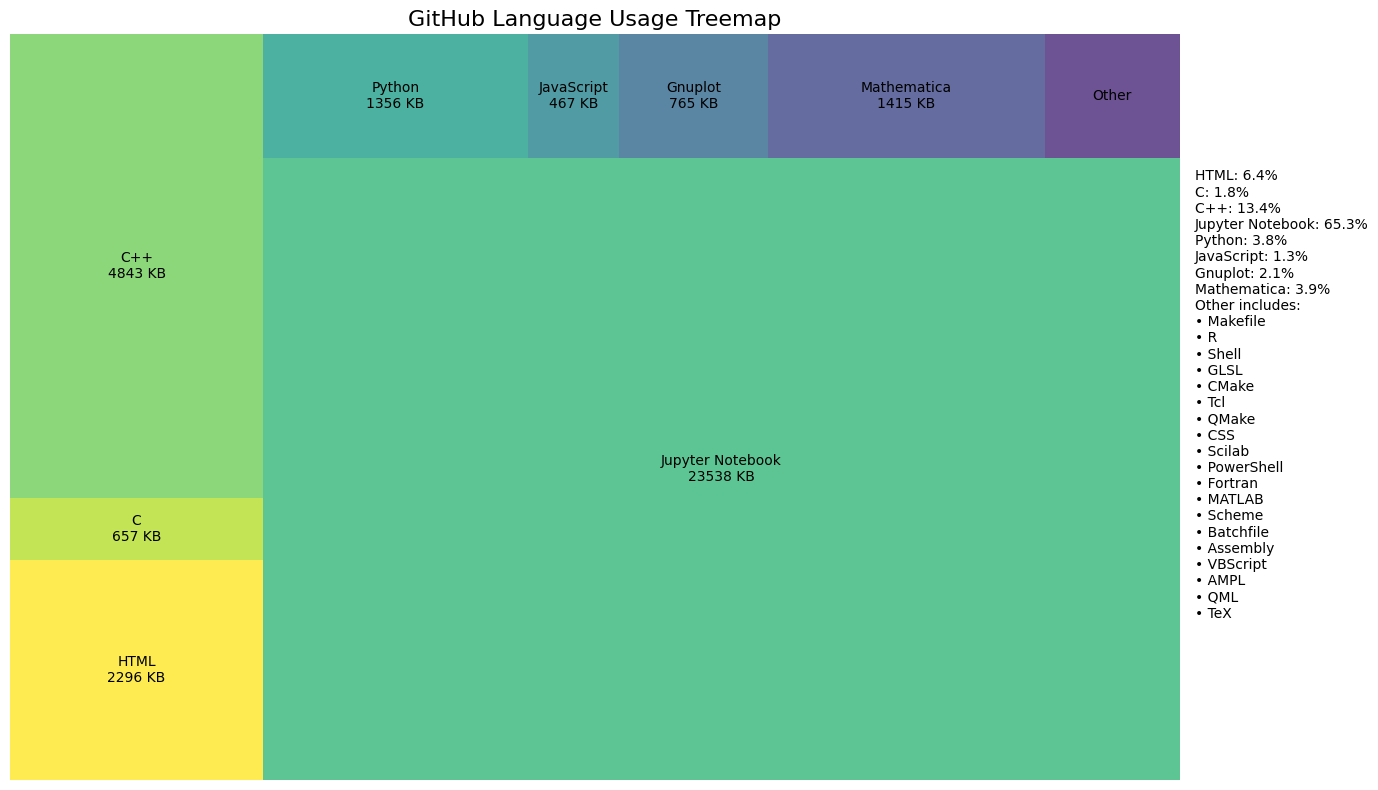

In [12]:
# --- MERGE SMALL LANGUAGES ---
total = sum(language_totals.values())
merged = {}
other_total = 0
other_langs = []

threshold_pct = 1

for lang, size in language_totals.items():
    pct = (size / total) * 100
    if pct < threshold_pct:
        other_total += size
        other_langs.append(lang)
    else:
        merged[lang] = size

if other_total > 0:
    merged["Other"] = other_total

# --- PREPARE PLOT DATA ---
sizes = list(merged.values())
labels = list(merged.keys())
label_text = [f"{k}\n{v/1000:.0f} KB" if k != "Other" else "Other" for k, v in zip(labels, sizes)]

# colors = plt.cm.tab20c([i / len(sizes) for i in range(len(sizes))])
colors = plt.cm.viridis_r([i / len(sizes) for i in range(len(sizes))])

# --- BUILD LEGEND ---
legend_lines = [f"{lang}: {size/total:.1%}" for lang, size in merged.items() if lang != "Other"]

if other_langs:
    legend_lines.append("Other includes:")
    legend_lines.extend([f"• {lang}" for lang in other_langs])


# --- DRAW TREEMAP ---
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=label_text, color=colors, alpha=0.8)
plt.axis("off")
plt.title("GitHub Language Usage Treemap", fontsize=16)

# --- LEGEND (percentages) ---
legend_labels = [f"{lang}: {size/total:.1%}" for lang, size in merged.items()]
# plt.figtext(1.0, 0.5, "\n".join(legend_labels), fontsize=10, va="center")
plt.figtext(1.0, 0.5, "\n".join(legend_lines), fontsize=10, va="center")

plt.tight_layout()
plt.show()

# commits

In [15]:
headers = {"Authorization": f"token {token}"} if token else {}

# --- GET COMMITS PER YEAR ---
commit_counts = defaultdict(int)

for repo in repos:
    repo_name = repo["name"]
    if repo["fork"]:  # Skip forked repos
        continue

    print(f"Processing repo: {repo_name}")
    page = 1

    while True:
        commits_url = f"https://api.github.com/repos/{username}/{repo_name}/commits?per_page=100&page={page}"
        commits = requests.get(commits_url, headers=headers).json()

        if not isinstance(commits, list) or not commits:
            break

        for commit in commits:
            try:
                date_str = commit["commit"]["author"]["date"]
                year = datetime.fromisoformat(date_str.replace("Z", "+00:00")).year
                commit_counts[year] += 1
            except (KeyError, TypeError):
                continue

        page += 1

Processing repo: 6way_tutorial_data
Processing repo: Alphaoo1
Processing repo: bn_to_walk_or_not
Processing repo: CMake_Tutorials
Processing repo: collect_location_data_survey
Processing repo: Computer-Vision-Classify-Dogs
Processing repo: Computer-Vision-Coral_detect
Processing repo: experiments_with_leaflet_interactive_webmaps
Processing repo: freeCodeCamp_ML_course
Processing repo: Frontend
Processing repo: LaTeX_Reports
Processing repo: leetcode
Processing repo: life_history_strategies
Processing repo: Nozzle_3D_page
Processing repo: prasadadhav
Processing repo: prasadadhav.github.io
Processing repo: process_location_data


## plot

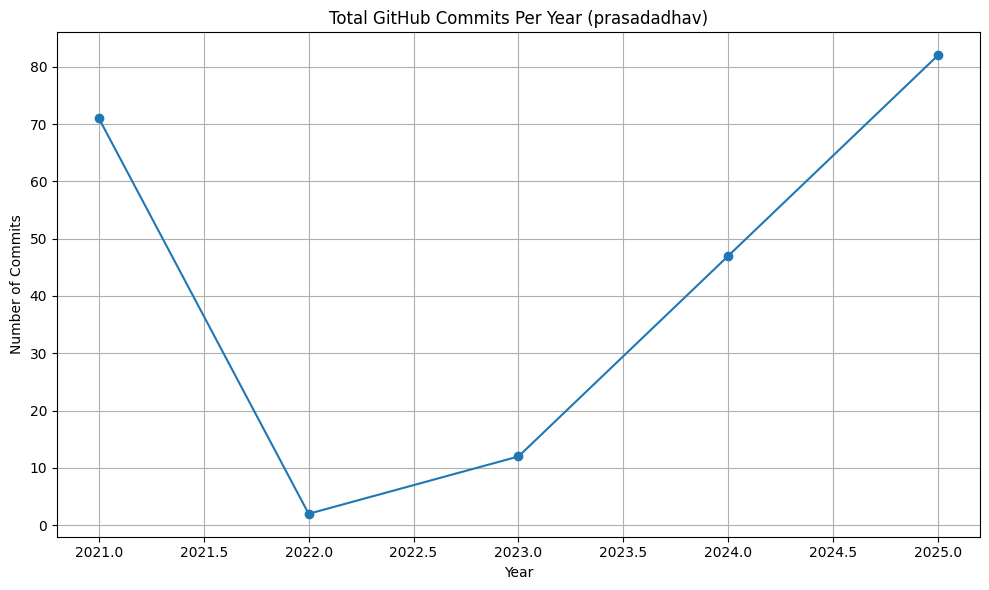

In [16]:
# --- PLOT ---
years = sorted(commit_counts.keys())
counts = [commit_counts[year] for year in years]

plt.figure(figsize=(10, 6))
plt.plot(years, counts, marker='o')
plt.title(f"Total GitHub Commits Per Year ({username})")
plt.xlabel("Year")
plt.ylabel("Number of Commits")
plt.grid(True)
plt.tight_layout()
plt.show()

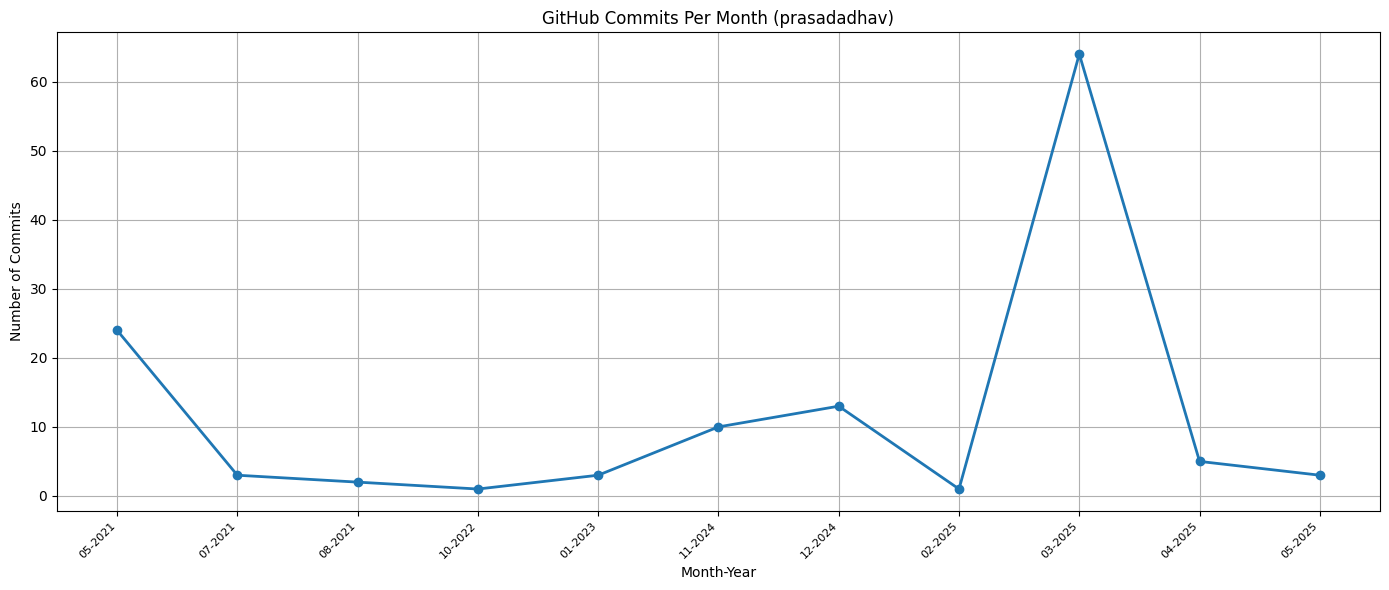

In [30]:
# --- GROUP COMMITS BY MONTH ---
from collections import defaultdict

monthly_counts = defaultdict(int)
for date, count in commit_counts.items():
    key = date.strftime("%m-%Y")  # e.g., "06-2023"
    monthly_counts[key] += count

# Sort by datetime
sorted_months = sorted(monthly_counts.items(), key=lambda x: datetime.strptime(x[0], "%m-%Y"))
months, counts = zip(*sorted_months)

# --- PLOT ---
plt.figure(figsize=(14, 6))
plt.plot(months, counts, marker='o', linewidth=2)
plt.title(f"GitHub Commits Per Month ({username})")
plt.xlabel("Month-Year")
plt.ylabel("Number of Commits")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# --- PREPARE EMPTY DAILY COUNTS ---
start_date = datetime(year, 1, 1)
end_date = datetime(year, 12, 31)
date_range = pd.date_range(start_date, end_date)
daily_commits = pd.Series(0, index=date_range)


In [23]:
# --- PROCESS COMMITS BY DAY ---
for repo in repos:
    if repo["fork"]:
        continue
    repo_name = repo["name"]
    page = 1

    while True:
        commits_url = (
            f"https://api.github.com/repos/{username}/{repo_name}/commits"
            f"?since={start_date.isoformat()}Z&until={end_date.isoformat()}Z"
            f"&per_page=100&page={page}"
        )
        res = requests.get(commits_url, headers=headers).json()
        if not isinstance(res, list) or not res:
            break

        for commit in res:
            try:
                date_str = commit["commit"]["author"]["date"]
                date = datetime.fromisoformat(date_str.replace("Z", "+00:00")).date()
                if start_date.date() <= date <= end_date.date():
                    daily_commits[pd.to_datetime(date)] += 1
            except Exception:
                continue

        page += 1

## heatmap

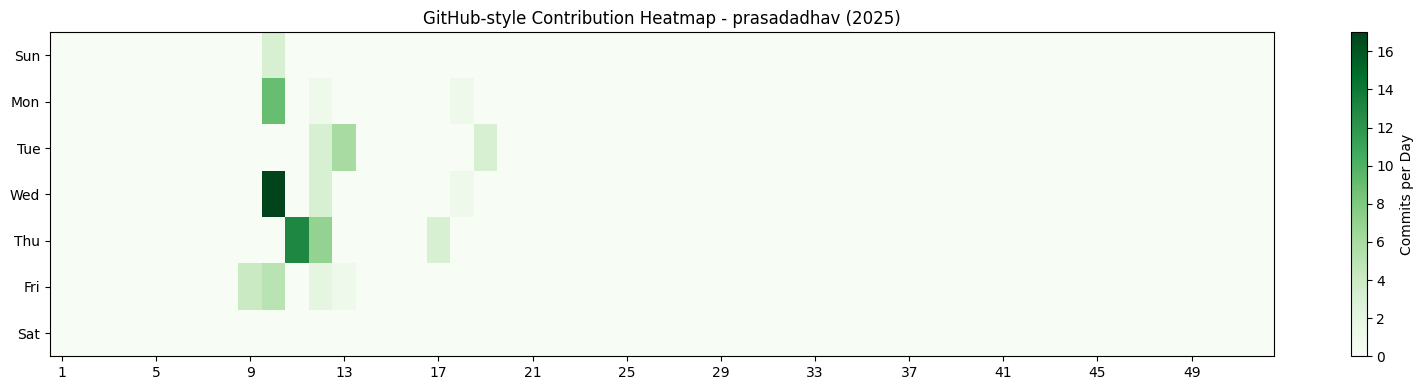

In [25]:
# --- CREATE DATAFRAME FOR HEATMAP ---
df = pd.DataFrame({"count": daily_commits})
df["weekday"] = df.index.weekday
df["week"] = df.index.to_series().apply(lambda d: d.isocalendar()[1])
df["month"] = df.index.month

# Handle week 52/53 overlap in Jan
df.loc[(df.index.month == 1) & (df["week"] > 50), "week"] = 0

# --- PIVOT TO GRID (week vs weekday) ---
# --- GROUP to ensure uniqueness ---
grouped = df.groupby(["weekday", "week"])["count"].sum().reset_index()

# --- PIVOT CLEANLY ---
grid = grouped.pivot(index="weekday", columns="week", values="count").fillna(0)
grid = grid.reindex(index=[6, 0, 1, 2, 3, 4, 5])  # GitHub-style: Sun–Sat

# --- PLOT ---
fig, ax = plt.subplots(figsize=(16, 4))
cmap = plt.cm.Greens
heat = ax.imshow(grid, cmap=cmap, aspect="auto", interpolation="none")

# Ticks and labels
ax.set_yticks(range(7))
ax.set_yticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
ax.set_xticks(range(0, len(grid.columns), 4))
ax.set_xticklabels(grid.columns[::4])
ax.set_title(f"GitHub-style Contribution Heatmap - {username} ({year})")

plt.colorbar(heat, ax=ax, label="Commits per Day")
plt.tight_layout()
plt.show()

## heatmap 2

Fetching: 6way_tutorial_data
Fetching: Alphaoo1
Fetching: bn_to_walk_or_not
Fetching: CMake_Tutorials
Fetching: collect_location_data_survey
Fetching: Computer-Vision-Classify-Dogs
Fetching: Computer-Vision-Coral_detect
Fetching: experiments_with_leaflet_interactive_webmaps
Fetching: freeCodeCamp_ML_course
Fetching: Frontend
Fetching: LaTeX_Reports
Fetching: leetcode
Fetching: life_history_strategies
Fetching: Nozzle_3D_page
Fetching: prasadadhav
Fetching: prasadadhav.github.io
Fetching: process_location_data


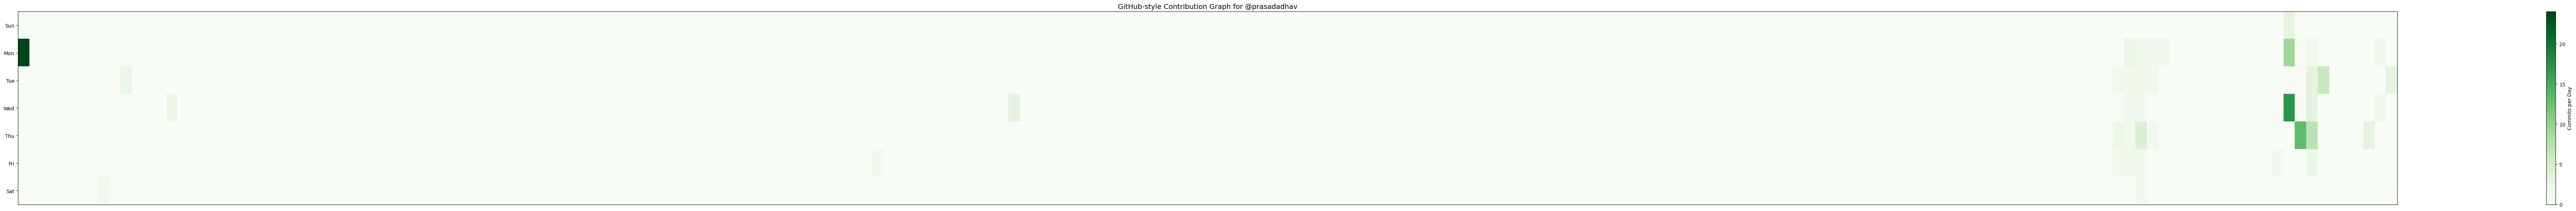

In [29]:
# --- COLLECT COMMITS ---
commit_counts = defaultdict(int)

for repo in repos:
    if repo.get("fork"):
        continue
    repo_name = repo["name"]
    print(f"Fetching: {repo_name}")
    page = 1
    while True:
        commits_url = f"https://api.github.com/repos/{username}/{repo_name}/commits?author={username}&per_page=100&page={page}"
        commits = requests.get(commits_url, headers=headers).json()
        if not isinstance(commits, list) or len(commits) == 0:
            break
        for commit in commits:
            try:
                date_str = commit["commit"]["author"]["date"]
                date = datetime.strptime(date_str[:10], "%Y-%m-%d").date()
                commit_counts[date] += 1
            except:
                continue
        page += 1

# --- BUILD DAILY COUNTS SERIES ---
if not commit_counts:
    print("No commit data found.")
    exit()

start_date = min(commit_counts.keys())
end_date = max(commit_counts.keys())
date_range = pd.date_range(start=start_date, end=end_date)
daily_commits = pd.Series(0, index=date_range)

for date, count in commit_counts.items():
    daily_commits[pd.to_datetime(date)] = count

# --- CREATE CONTRIBUTION GRID ---
df = pd.DataFrame({"count": daily_commits})
df["dow"] = df.index.dayofweek  # 0 = Monday
df["week"] = df.index.to_series().apply(lambda d: d.isocalendar()[1])
df["year"] = df.index.year
df["week_index"] = ((df.index - pd.to_datetime(df.index[0])).days // 7).astype(int)

pivot = df.pivot(index="dow", columns="week_index", values="count").fillna(0)
pivot = pivot.reindex(index=[6, 0, 1, 2, 3, 4, 5])  # Sunday on top

# --- PLOT IT LIKE GITHUB ---
fig, ax = plt.subplots(figsize=(pivot.shape[1] / 2.5, 6))
cmap = plt.cm.Greens
norm = mcolors.Normalize(vmin=0, vmax=max(1, pivot.values.max()))
im = ax.imshow(pivot, aspect="auto", cmap=cmap, norm=norm)

# GitHub-like style
ax.set_xticks([])
ax.set_yticks(range(7))
ax.set_yticklabels(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
ax.set_title(f"GitHub-style Contribution Graph for @{username}", fontsize=14)

plt.colorbar(im, ax=ax, orientation="vertical", label="Commits per Day")
plt.tight_layout()
plt.show()